# RL homework 1
**Due date: Monday 4 February 2019, 9am**

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

Name: ***Oliver Wesely***

Student number: ***18057603***

**How to submit**

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`studentnumber_RL_hw1.ipynb`** before the deadline above.

We will process the notebook with a tool similar to Jupyter nbconvert, to turn it into a PDF, while excluding the cells with code (many of which are boilerplate).  If you carefully follow the instructions, the coding you have to do will be printed to output as well, and therefore will show up in the PDF.  Feel free to create a PDF with nbconvert as well, if you want to check whether everything looks okay.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 and 2

**Overview of this assignment**

You will use Python to implement several bandit algorithms.

You will then run these algorithms on a multi-armed Bernoulli bandit problem, to understand the issue of balancing exploration and exploitation.

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section with the little triangle on the left of the word **Setup** above.

In [0]:
# Import Useful Libraries

import collections
from functools import partial
import importlib
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [0]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [0]:
class RovingBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=500,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [0]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 3
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(8, 3*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)

  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg in current_algs:
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.6, label=alg.name)[0]
        else:
          line = plt.plot(m, alpha=0.6, label=alg.name)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], '--k', label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=30,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.25, 0.75 + 1e-6, 0.5/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

## Basic Agents

This section contains a few agents we implemented for you.  Please read the code and make sure you understand the interface of the agents.

In [0]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = 'random'

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass

In [0]:
class Greedy(object):
  """A greedy agent.

  This agent returns an action between 0 and 'number_of_arms', by always
  selecting the action with the highest estimated value.
  """

  def __init__(self, number_of_arms):
    """Initialise the agent."""
    self._number_of_arms = number_of_arms
    self.name = 'greedy'
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    
    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input).  Then, the greedy action
    is returned according to the current (updated) statistics.
    
    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action is not None:
      self._counts[previous_action] += 1.
      r = reward
      q_a = self._estimates[previous_action]
      n_a = self._counts[previous_action]
      self._estimates[previous_action] += (r - q_a)/n_a
    action = argmax(self._estimates)
    
    return action

  def reset(self):
    """Resets all the statistics (estimated rewards and counts) to zero.
    
    This is also used to initialise these statistics on initialisation.
    """
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts = np.zeros((self._number_of_arms,))

In [0]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, number_of_arms, epsilon=0.1):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.name = '$\epsilon$-greedy with $\epsilon$ = {}'.format(epsilon)
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    
    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).
    
    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action is not None:
      self._counts[previous_action] += 1.
      r = reward
      q_a = self._estimates[previous_action]
      n_a = self._counts[previous_action]
      self._estimates[previous_action] += (r - q_a)/n_a
    if np.random.random() < self._epsilon:
      action = np.random.randint(self._number_of_arms)
    else:
      action = argmax(self._estimates)
    return action

  def reset(self):
    """Resets all the statistics (estimated rewards and counts) to zero.
    
    This is also used to initialise these statistics on initialisation.
    """
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts = np.zeros((self._number_of_arms,))

# REINFORCE: softmax policies

Derive a REINFORCE policy-gradient method for a multi-armed bandit problem.

The policy is a softmax on action preferences, with temperature T:
$$\pi(a) = \frac{\exp(p(a)/T)}{\sum_b \exp(p(b)/T)}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

In the next text field (under **Q1**), write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$, given the preferences $p_t(\cdot)$, and assuming you selected a specific action $A_t \in \{a_1, \ldots, a_n\}$ and received a reward of $R_t$.

## Q1
**[5 pts]** **Instructions**: please provide answer **in this text cell**:

*Answer here*
\begin{align*}
p_{t+1}(a)
& = p_t(a)+\alpha R_t \frac {1}{T}(1-\pi_t(a))
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& = p_t(b)-\alpha R_t \frac {1}{T}\pi_t(b)
&& \text{for all $b \ne A_t$}
\end{align*}

# REINFORCE: different parametrization

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice.

Consider for instance the `square-max` policy parameterization, on action preferences $p(\cdot)$:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Derive a REINFORCE policy-gradient method for updating the preferences under this policy distribution.

As before, the action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

In the next text field (under **Q2**), write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$,
given the preferences $p_t(\cdot)$, and assuming you selected a specific action $A_t \in \{a_1, \ldots, a_n\}$ and received a reward of $R_t$.

## Q2
**[5 pts]** **Instructions**: please provide answer in markdown below **within this text cell**.

*Answer here*
\begin{align*}
p_{t+1}(a)
& = p_t(a)+\alpha R_t \frac {2}{p_t(a)}(1-\pi_t(a))
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& = p_t(b)-\alpha R_t \frac {2}{p_t(b)}\pi_t(b)
&& \text{for all $b \ne A_t$}
\end{align*}

# Agent implementations


All agents should be in pure Python.

You cannot use TensorFlow or other AutoDiff packages to compute gradients.

It is fine to use TF-Eager or Numpy for other calculations.

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

The `name` attribute set by the agent's constructor should be unique (e.g., 'greedy', 'ucb', etc.)



## Q3
**[10 pts]** You should **implement** an agent that **explores with UCB**. 

The **whole agent** needs to be contained in the code cell below.  Do **not** use multiple cells.

In [12]:
%%writefile rl1_3.py 

class UCB(object):
  """A UCB.

  This agent returns an action between 0 and 'number_of_arms', by always
  selecting the action with the highest UCB: Q_t(a)+ U_t(a),
  where U_t(a)=c*sqrt(log(t)/N_t(a)). c can be considered a hyperparameter,
  but I am using c=1/sqrt(2) as in the lecture slides.
  """
  def __init__(self, number_of_arms,c=1/np.sqrt(2)):
    """Initialise the agent."""
    self._number_of_arms = number_of_arms
    self.name = 'ucb'
    self.c=c
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    
    
    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    If any of the actions a has N_t(a)=0, then it's considered to be a maximizing
    action.
    
    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action is not None:
      self._counts[previous_action] += 1
      q_a = self._estimates[previous_action]
      n_a = self._counts[previous_action]
      self._estimates[previous_action] += (reward - q_a)/n_a
    
    t=np.sum(self._counts)
    """
    As described in the book if Nt(a) = 0, then a is considered to be a
    maximizing action so in the first 'number_of_arms' steps every different
    action will tried once.
    """
    for i in range(self._number_of_arms):
      if self._counts[i]==0:
        return i
    
    u_a = self.c*np.sqrt(np.log(t) / (self._counts))
    action = np.argmax(u_a+self._estimates)
    return action
    
  def reset(self):
    """Resets all the statistics (estimated rewards and counts) to zero.
    This is also used to initialise these statistics on initialisation.
    """
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts = np.zeros((self._number_of_arms,))

Writing rl1_3.py


In [13]:
# Don't modify this cell
print('** Answer 3')
print('[10 pts]')
f = open('rl1_3.py')
ucb_string = ''.join(f.readlines())
exec(compile(ucb_string, 'ucb', 'exec'))
print(ucb_string)
f.close()

** Answer 3
[10 pts]

class UCB(object):
  """A UCB.

  This agent returns an action between 0 and 'number_of_arms', by always
  selecting the action with the highest UCB: Q_t(a)+ U_t(a),
  where U_t(a)=c*sqrt(log(t)/N_t(a)). c can be considered a hyperparameter,
  but I am using c=1/sqrt(2) as in the lecture slides.
  """
  def __init__(self, number_of_arms,c=1/np.sqrt(2)):
    """Initialise the agent."""
    self._number_of_arms = number_of_arms
    self.name = 'ucb'
    self.c=c
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    
    
    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    If any of the actions a has N_t(a)=0, then it's considered to be a maximizing
    action.
    
    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still

## Q4

**[10 pts]** You should **implement a softmax REINFORCE agent with** and **without a baseline**.

The **whole agent** needs to be contained in the code cell below.  Do **not** use multiple cells.

The constructor should take as arguments:
*  `number_of_arms`, (int), number of discrete actions,
*  `baseline`: (boolean, default False), whether or not to use an average-reward baseline,
*  `step_size`: (float, default 0.1), the step-size for the updates,
*  `temperature`: (float, default 1.0), the temperature of the softmax policy, .


In [14]:
%%writefile rl1_4.py
class REINFORCE(object):

  def __init__(
      self, number_of_arms, step_size=0.1, baseline=False, temperature=1.0):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self._baseline = baseline
    self._temperature = temperature
    self.name = 'reinforce, baseline: {}, temperature: {}'.format(
        baseline, temperature)
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    Softmax Reinforce with(/out) baseline
    
    This agent returns an action between 0 and 'number_of_arms', by always
    selecting an action due to the current preference distribution p(A_t)
    of action A_t.
    
    p_t+1(a)=p_t(a)+alpha*(R_t - mean(R_t))*(indicator(a=A_t)-pi(A_t))
    
    where alpha is the step-size(default 0.1) and the mean reward is the
    baseline (default=False). pi(A_t) is the softmax including temperature T.
    """
    if previous_action is not None:
      #If we use a baseline we have to evaluate the average reward
      if self._baseline == True:
        self._average_reward *= self._count
        self._average_reward += reward
        self._count += 1
        self._average_reward /= self._count
      
      pi=self.softmax()#Preferences according to a soft-max distribution
      
      diffcalc=np.zeros((self._number_of_arms,))
      diffcalc[previous_action]=1 #unit vector of previous_action
      #new preferences:
      self._preference +=self._lr*(reward-self._average_reward)*(diffcalc-pi)/self._temperature
      #action choosen due to the preference distribution:
      action = np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    
    #If previous action is None, therefor at t=1 we choose a random action.
    else:
      action = np.random.randint(self._number_of_arms)
    
    return action
  
  def softmax(self):
    return np.exp(self._preference/self._temperature)/np.sum(np.exp(self._preference/self._temperature))
  
  def reset(self):
    """Resets all the statistics (estimated rewards and counts) to zero.
    This is also used to initialise these statistics on initialisation.
    """
    self._preference = np.zeros((self._number_of_arms,)) #p(a).. preferences of all actions
    #Following two variables will only be used when we have a baseline:
    self._count=0 
    self._average_reward = 0

Writing rl1_4.py


In [15]:
# Don't modify this cell
print('** Answer 4')
print('[10 pts]')
f = open('rl1_4.py')
reinforce_string = ''.join(f.readlines())
exec(compile(reinforce_string, 'reinforce', 'exec'))
print(reinforce_string)
f.close()

** Answer 4
[10 pts]
class REINFORCE(object):

  def __init__(
      self, number_of_arms, step_size=0.1, baseline=False, temperature=1.0):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self._baseline = baseline
    self._temperature = temperature
    self.name = 'reinforce, baseline: {}, temperature: {}'.format(
        baseline, temperature)
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    Softmax Reinforce with(/out) baseline
    
    This agent returns an action between 0 and 'number_of_arms', by always
    selecting an action due to the current preference distribution p(A_t)
    of action A_t.
    
    p_t+1(a)=p_t(a)+alpha*(R_t - mean(R_t))*(indicator(a=A_t)-pi(A_t))
    
    where alpha is the step-size(default 0.1) and the mean reward is the
    baseline (default=False). pi(A_t) is the softmax including temperature T.
    """
    if previous_action is not None:
      #If we use a 

# Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [0]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(number_of_arms),
    Greedy(number_of_arms),
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


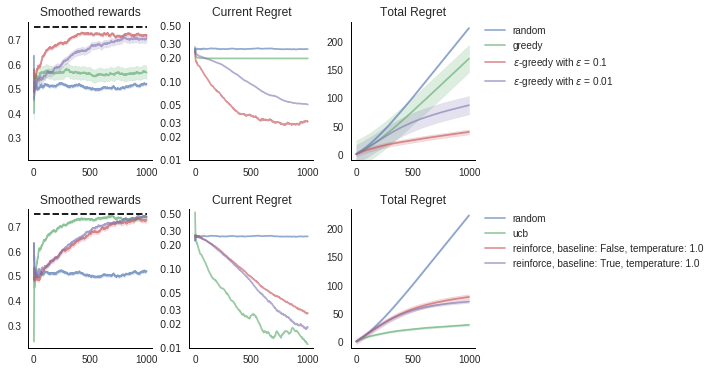

In [17]:
experiment1.show()

## Q5
(Answer inline in the markdown below each question, **within this text cell**.)

**[5pts]** Name the best and worst algorithms, and explain (with one or two sentences each) why these are best and worst.

The random algorithm is obviously the worst algorithm, simply because it does not choose an action due to the feedback it receives from the environment. The random algorithm just chooses any random arm without keeping any priorly acquired knowledge.

In this case UCB algorithm is the best algorithm as its smoothed rewards are the highest and its current regrets drops the fastest and converges nearly to zero. This is the case because it takes the uncertainty of all actions into account and does not just take the one with the highest estimate. 

**[5pts]** Which algorithms are guaranteed to have linear total regret?

*Random, greedy and $\epsilon$-greedy algorithms are guaranteed to have linear total regret. Decaying $\epsilon$-greedy would have logarithmic asymptotic total regret, which sometimes is called sublinear in the literature.

**[5pts]** Which algorithms are guaranteed to have logarithmic total regret?

*REINFORCE with and without baseline has asymptotic logarithmic total regret.*

*Also the UCB algorithm, with $c=sqrt(2)$, achieves logarithmic expected total regret, due to (Auer et al., 2002).*

**[5pts]** Which of the $\epsilon$-greedy algorithms performs best?  Which should perform best in the long run?

*The $\epsilon$-greedy algorithm with $\epsilon=0.1$ performs better within 1000 steps, but looking at the long run, the other one with the lower $\epsilon$, $\epsilon=0.01$, should perform better. As the one with $\epsilon=0.01$ only explores with a probability of $0.01$ and therefore keeps exploiting longer as the other one. But it is better in the long run as of its lower exploration rate.*

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [0]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

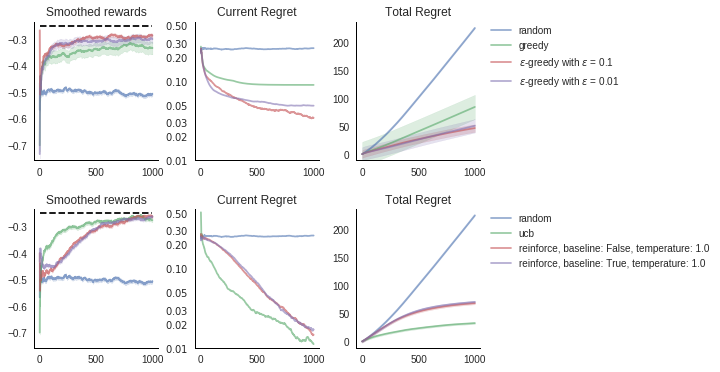

In [19]:
experiment2.show()

## Q6
**[10pts]** Explain which algorithms improved from the changed rewards, and why.

(Use at most two sentences per algorithm and feel free to combine explanations for different algorithms where possible).

*The most improvement comparing these two models can be observed in the greedy algorithm, its smoothed rewards and total regret are not sufficiently different to the $\epsilon$-greedy ones any more. This comes from the evaluation of the estimates, as the failure reward is now -1 and penalises the agent instead of just have reward 0. So with changing the rewards like this the agent will be forced to do more exploration and don't exploit too early. The same reasoning applies to both $\epsilon$-greedy algorithms, but it can be seen that the change of rewards like this especially improves the algorithm with a lower $\epsilon$ value as it then tend to explore far less than the higher one,$\epsilon=0.1$, its rewards does not really change that much.*

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [0]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984

agents = [
    
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

roving_bandit_class = partial(RovingBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [0]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984

agents = [
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

roving_bandit_class = partial(RovingBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

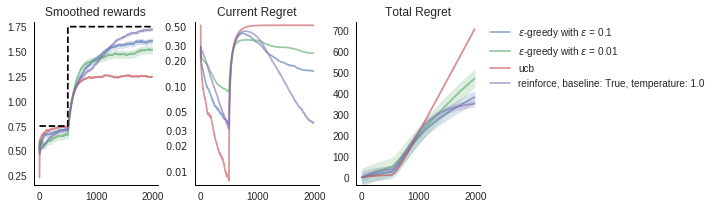

In [22]:
experiment3.show()

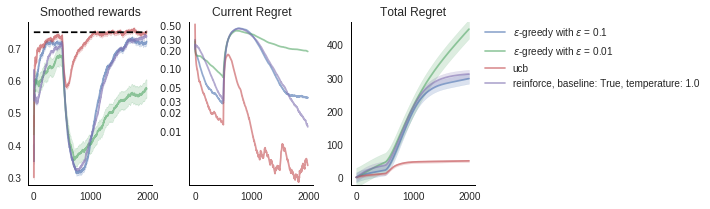

In [23]:
experiment4.show()

## Q7

Observe the reward and regret curves above.  After 500 steps, the rewards change: `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2, which means that the identity of the optimal action changes.

Below, we ask for explanations.  Answer each question briefly, *using at most three sentences per question*.

**[10 pts]** Look at the current-regret curve for UCB in **experiment 3**.  Explain why it looks the way it does after the change in rewards.

*Until step 500 UCBs current regret curve is the same as in experiment 1, after the change of failure to a reward of +2 instead of 0  its current regret starts increasing pretty fast as of all the other algorithms do, but not like the others it fails to adapt the new settings and is stuck at the success reward. This happens because the estimates of the actions depend on the uncertainty of its rewards and the change of the rewards will not be reflected in the estimates and the main problems is that the success reward, with the initially higher reward, does not change after step 500 so the UCB does not explore the new reward of failure, which would higher, and therefore keeps on having current regrets of 0.5.*

**[6 pts]** Explain why the current-regret curves for $\epsilon$-greedy look different than that of UCB in **experiment 3**.

*Both $\epsilon$-greedy algorithms' current regret peek after reward changes at step 500, but unlike UCB the current regrets go down again after a certain amount of steps. This comes due to the fact that even after 500 steps the $\epsilon$-greedy algorithms keep exploring, the more exploring the higher the $\epsilon$ value is, so the perfomance of these two algorithms can be brought down after spiking up and will keep improving even if its not that fast.*

**[6 pts]** Explain why the current-regret curve for REINFORCE looks different than that of UCB in **experiment 3**.

*Unlike any other algorithm REINVORCE adapted the change fastest and nearly reached his current regret value which it had at step 500 after a total of about 2000 steps. This is due to the gradient-based definition of the formula, including to evaluate the rewards based gradient after each step, so it easily gets aware of changes within the settings of the model.*

**[6 pts]** Compare the current-regret curve for UCB in **experiment 3** to the current regret curve of UCB in **experiment 4**.  Explain why they differ.

*Comparing experiment 3 and 4 the main difference is the fact that in experiment 4 not only the failure reward was increased, this time only to +1, but also the success reward was changed to 0 instead of +1 after 500 steps. Therefor UCB cannot stick to the success rewards and keeps starting exploring again pretty soon, so its significantly increased current regret drops down pretty fast. *

**[6 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify the $\epsilon$-greedy algorithm implemented above to deal with that better?  Be specific and concise.

*We could modify the algorithm in the way of evaluating the variance of the last $2/\epsilon$ Q values and increase epsilon dependent on this variance which keeps getting the algorithm again more exploring if the variance is getting higher, which is the case when different rewards occur. We could also apply a sliding window approach or even can just increase $\epsilon$ regularly to a higher value after a random amount of time steps for some steps to explore all different rewards again and get back to the old $\epsilon$ value.*

**[6 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

*To catch changes in rewards we should keep the agent exploring different actions and therefore should possibly increase parameter c with time. This would make sure that not just the exploited value will be taken but potential non greedy estimates will be taken into account. We could also use a discount factor which is higher for recent rewards and therefore could evaluate current estimates and take them into account or as for the $\epsilon$-algorithms we could also use the sliding window approach .*